In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import kaggle
import pandas
import tableone
from tableone import TableOne, load_dataset
import scipy
from scipy.stats import chi2_contingency

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# downloading from kaggle.com/c/sentiment-analysis-on-movie-reviews
# there are two files, train.tsv.zip and test.tsv.zip
# we write to the current directory with './'
api.competition_download_file('titanic',
                              'gender_submission.csv', path='./data/')
api.competition_download_file('titanic',
                              'train.csv', path='./data/')
api.competition_download_file('titanic',
                              'test.csv', path='./data/')

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')


gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
pd.DataFrame.head(df_train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
# We can define a new variable as family size

df_train["Family"] = df_train["SibSp"] + df_train["Parch"]

In [5]:
categorical = ['Parch', 'SibSp', 'Sex', 'Embarked', 'Pclass']

table1 = TableOne(df_train.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Survived'], axis = 1), dip_test=True, normal_test=True, tukey_test=True, categorical = categorical)
table1

Missing      Overall
n                                         891
Pclass, n (%)     1            0   216 (24.2)
                  2                184 (20.7)
                  3                491 (55.1)
Sex, n (%)        female       0   314 (35.2)
                  male             577 (64.8)
Age, mean (SD)               177  29.7 (14.5)
SibSp, n (%)      0            0   608 (68.2)
                  1                209 (23.5)
                  2                  28 (3.1)
                  3                  16 (1.8)
                  4                  18 (2.0)
                  5                   5 (0.6)
                  8                   7 (0.8)
Parch, n (%)      0            0   678 (76.1)
                  1                118 (13.2)
                  2                  80 (9.0)
                  3                   5 (0.6)
                  4                   4 (0.4)
                  5                   5 (0.6)
                  6                   1 (0.1)
Fare, mean (SD)                0  32.2 (49.7)
Embarked, n (%)   C            2   168 (18.9)
                  Q                  77 (8.7)
                  S                644 (72.4)
Family, mean (SD)              0    0.9 (1.6)
[1] Hartigan's Dip Test reports possible
                                  multimodal distributions for: Age, Fare, Family.
[2] Normality test reports non-normal
                                  distributions for: Age, Fare, Family.
[3] Tukey test indicates far outliers
                                  in: Fare, Family.

## Adressing the warnings of Hartigan's Dip, Normality and Tukey Test

(-25.0, 200.0)

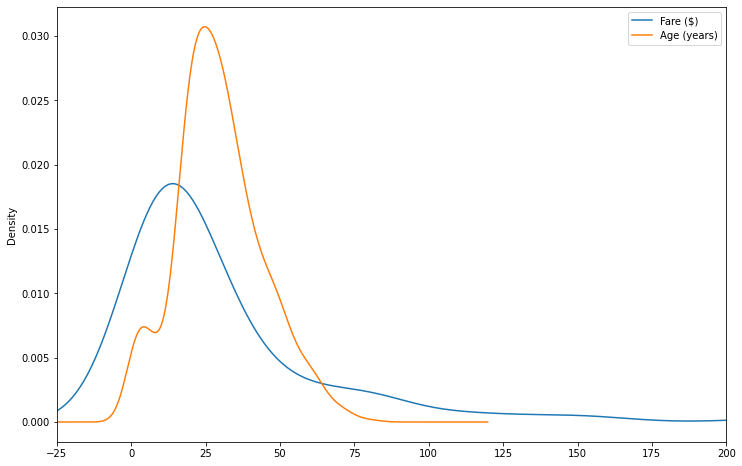

In [6]:
df_train[['Fare', 'Age']].dropna().plot.kde(figsize=[12,8])
plt.legend(['Fare ($)', 'Age (years)'])
plt.xlim([-25, 200])

(-10.0, 15.0)

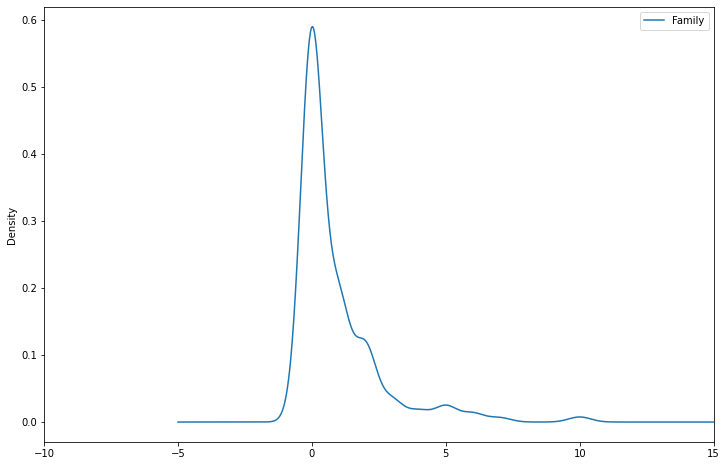

In [7]:
df_train[['Family']].dropna().plot.kde(figsize=[12,8])
plt.legend(['Family'])
plt.xlim([-10, 15])

For Fare:
* There is a slight concentration of values around the $75 mark however, this is not large enough to qualify it as a bimodal distribution.
* The distribution is not normal since it has a sizeable right tail. 
* As Tukey's test indicates, there are outliers in fare which contribute to non-normality; this is shown wherein the range of fare is [0, 512]. This may violate some assumptions of predictor normality in model development.

For Age:
* There is a definite concentration of values between 0-10 years of age. This suggests that there was a sizeable proportion of passengers who were children, making Age a bimodal distribution instead of normal.
* This may contribute to issues in models that assume normal distributions for predictors, particularly Age.

For Family:
* It is clearly a non-normal distribution (since the variable is discrete - this may be why). There are multiple modes at 0, 3, 5 and 10. 
* This may violate assumptions of normality.

In [8]:
groupby = ['Survived']
nonnormal = ['Age', 'Fare']
limit = {"Survived": 1}

table1 = TableOne(df_train.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis = 1), groupby=groupby, categorical = categorical, nonnormal=nonnormal, limit = limit)
table1

Grouped by Survived                                                      
                                        Missing           Overall                 0                 1
n                                                             891               549               342
Pclass, n (%)        1                        0        216 (24.2)         80 (14.6)        136 (39.8)
                     2                                 184 (20.7)         97 (17.7)         87 (25.4)
                     3                                 491 (55.1)        372 (67.8)        119 (34.8)
Sex, n (%)           female                   0        314 (35.2)         81 (14.8)        233 (68.1)
                     male                              577 (64.8)        468 (85.2)        109 (31.9)
Age, median [Q1,Q3]                         177  28.0 [20.1,38.0]  28.0 [21.0,39.0]  28.0 [19.0,36.0]
SibSp, n (%)         0                        0        608 (68.2)        398 (72.5)        210 (61.4)
                     1                                 209 (23.5)         97 (17.7)        112 (32.7)
                     2                                   28 (3.1)          15 (2.7)          13 (3.8)
                     3                                   16 (1.8)          12 (2.2)           4 (1.2)
                     4                                   18 (2.0)          15 (2.7)           3 (0.9)
                     5                                    5 (0.6)           5 (0.9)                  
                     8                                    7 (0.8)           7 (1.3)                  
Parch, n (%)         0                        0        678 (76.1)        445 (81.1)        233 (68.1)
                     1                                 118 (13.2)          53 (9.7)         65 (19.0)
                     2                                   80 (9.0)          40 (7.3)         40 (11.7)
                     3                                    5 (0.6)           2 (0.4)           3 (0.9)
                     4                                    4 (0.4)           4 (0.7)                  
                     5                                    5 (0.6)           4 (0.7)           1 (0.3)
                     6                                    1 (0.1)           1 (0.2)                  
Fare, median [Q1,Q3]                          0   14.5 [7.9,31.0]   10.5 [7.9,26.0]  26.0 [12.5,57.0]
Embarked, n (%)      C                        2        168 (18.9)         75 (13.7)         93 (27.4)
                     Q                                   77 (8.7)          47 (8.6)          30 (8.8)
                     S                                 644 (72.4)        427 (77.8)        217 (63.8)
Family, mean (SD)                             0         0.9 (1.6)         0.9 (1.8)         0.9 (1.2)

## Analysis of TableOne

We can notice some trends from this TableOne particularly, the associations of Pclass, Sex, Fare and Embarked with survival (outcome).
The rest of the variables do not show strong association. 

1. Pclass
* A larger proportion of first class passengers survived (2-1), as compared to second class passengers (roughly 1-1) and much better than third class passengers (roughly 1-2).
* More than twice as many passengers died, as survived in third class (372 dead vs. 119 alive).

2. Sex
* Generally, females had a greater chance of surviving, seeing about only 1 death per 4 female passengers surviving.
* The trend for males was the inverse, having a worse chance of surviving, seeing more than 4 deaths per 1 male passenger surviving. 

3. Fare
* Fare is directly tied to passenger class. A higher fare generally implies a higher class of cabin. 
* Hence, we would see the fare distribution of surviving passengers to be much higher than the fare distribution of dead passengers.
* This is indeed the case, as surviving passengers had an average fare of $26, more than twice the average fare of dead passengers ($10.5)
* For the future correlation plot, we can expect to see strong correlations between Pclass, Fare and mortality.

4. Family
* Those with more than 1 family member were more likely to survive. If a passenger had no family, they were more likely to die than survive (68% vs. 47%).

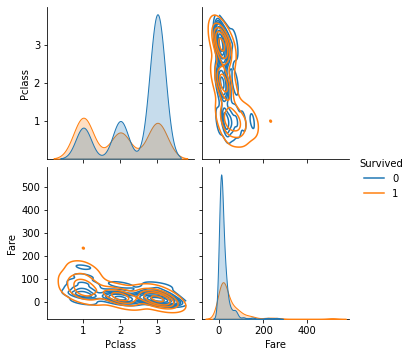

In [9]:
sns.pairplot(data = df_train, x_vars=["Pclass", "Fare"], y_vars=["Pclass", "Fare"], hue = 'Survived', kind = 'kde')

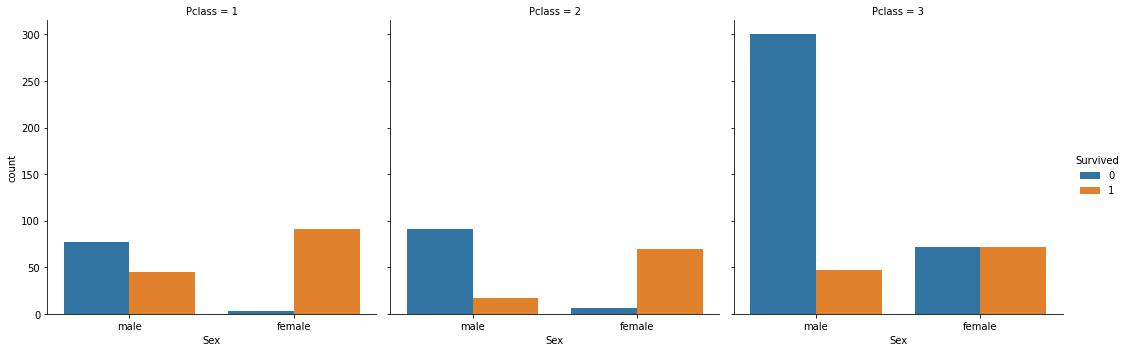

In [10]:
sns.catplot(x="Sex", hue="Survived", col = "Pclass", data=df_train, kind = "count", )

## Plots

The plots show the same trends as TableOne.
We can see that:
* The relative proportion of surviving passengers is much higher for those in higher passenger classes, and lower fare.
* A female passenger was more likely to survive, and this trend is seen across passenger classes. Only in third class, females were equally likely to die as survive. However, even then, the death rate of third class passengers is far greater comparatively.

In [11]:
## From our data


In [12]:
X = df_train.drop(columns=["Survived"], axis = 1)
Y = df_train.loc[:,"Survived"]

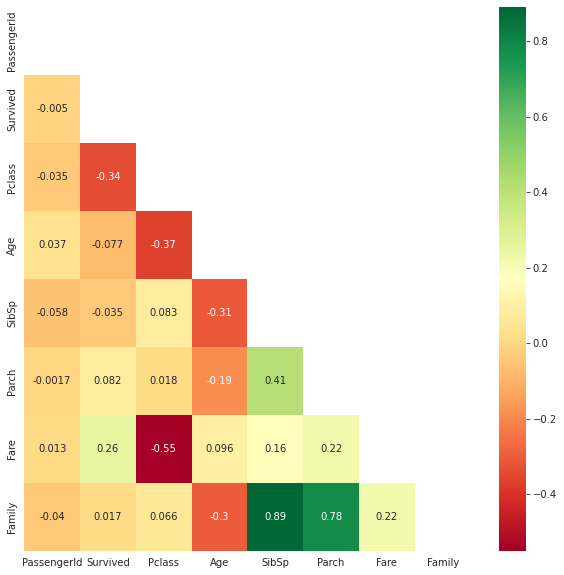

In [13]:
corrmat = df_train.corr(method = "spearman")
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
with sns.axes_style("white"):
    sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn", mask = mask)

## Correlation Matrix

From the correlation matrix we can see some important correlations between predictors:
* Fare vs. Pclass: A higher fare is strongly negatively correlated with Pclass (-0.55). This is because a lower numerical Pclass is tied to a higher fare (Pclass 1 > 2 > 3). Both are tied to outcome (survival) with moderate correlations as well. 
* Age vs. Pclass: It seems that younger passengers were in third or second class, rather than first class. 
* Parch vs. SibSp: Those who had parents on-board were also more likely to have siblings on-board. 
* Survived vs. Fare vs. Pclass: The strongest correlations for the outcome are between fare price vs. survival and pclass vs. survival. 
* Sex: Sex is important as we have seen in the dataviz plots, but it is not possible to compute a correlation. Instead we can do a chi-square test.

## Chi-Sq test for Sex

In [14]:
pd.crosstab(df_train['Sex'], df_train['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [15]:
scipy.stats.chi2_contingency([[81, 233], [468, 109]])

(260.71702016732104,
 1.1973570627755645e-58,
 1,
 array([[193.47474747, 120.52525253],
        [355.52525253, 221.47474747]]))

The result is extremely significant, showing that Sex has a direct impact on survival. 

## Conclusion:

* Using basic data visualization, we have determined that Sex, Fare and Pclass are the most important predictors for mortality.
* However, other variables will still be used in a nested CV approach in order not to exclude any variables that might contribute to variation.
* Given our data visualization results, we should expect Sex, Fare and Pclass to be the most important predictors in our final model.
* We should be cautious particularly about Fare and Age (due to non-normality).